
<img src="https://cursos.virtual.uniandes.edu.co/isis4219/wp-content/uploads/sites/162/2014/11/cropped-misisheader.png" ><br>
# Machine Learning Techniques - ISIS4219

Intersemestral 2020


* Daury Lecca
* Nicolas Lema
* Alejandro Martínez
* David Ortiz


**1. Instalación de librerias a utilizar**

In [1]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install contractions
!pip install feedparser
!pip install newspaper3k
!pip install pandas_profiling
import nltk
nltk.download()

     - 26.8 MB 2.7 MB/s
  Created wheel for pandas-profiling: filename=pandas_profiling-2.9.0rc1-py2.py3-none-any.whl size=258106 sha256=700814bea88de9d0eb32708c2551ee0f9d7ca6ec96c3b58134384d12d790976f
  Stored in directory: /tmp/pip-ephem-wheel-cache-82m_n4a4/wheels/cc/d5/09/083fb07c9363a2f45854b0e3a7de7d7c560f07da74b9e9769d
Successfully built pandas-profiling
  Attempting uninstall: pandas-profiling
    Found existing installation: pandas-profiling 2.8.0
    Uninstalling pandas-profiling-2.8.0:
      Successfully uninstalled pandas-profiling-2.8.0
You should consider upgrading via the '/home/alejitro/ml/ml_env/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/alejitro/ml/ml_env/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/alejitro/ml/ml_env/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/alejitro/ml/ml_env/bin/python -m pip install --upgrade pi

True

In [2]:
import pandas as pd
import numpy as np
import sys
from pandas_profiling import ProfileReport


import nltk
import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve

import matplotlib.pyplot as plt

In [3]:
import json

**2. Perfilamiento y entendimiento de los datos**



* Lectura de los datos

A continuación procedemos a leer los datos del Dataset de Kaggle, los cuales ya estan dividos entre Fake news y Real News.

Despues te esto, hacemos un proceso de web scrapping de diferentes medios que tienen noticias reales y falsas para aumentar el tamaño de la muestra y la diversidad de noticias de nuestro dataSet y tener noticias de un contexto mas actual ya que las del dataset de kaggle estan en un periodo comprendido entre 2016 y 2018

In [4]:
def get_data(dataset):
    if(dataset=='true'):
        url = 'https://raw.githubusercontent.com/alejitro/proyecto_MLT_Grupo05/master/DataSet/True.csv'
        return pd.read_csv(url,error_bad_lines=True)
    elif(dataset=='false'):
        url = 'https://raw.githubusercontent.com/alejitro/proyecto_MLT_Grupo05/master/DataSet/Fake.csv'
        return pd.read_csv(url,error_bad_lines=True)
    else:
        return ("No data")

* Medios de los cuales se van a obtener noticias recientes:

In [5]:
dictionary = {
  "bbc": {
    "rss": "http://feeds.bbci.co.uk/news/rss.xml",
    "link": "http://www.bbc.com/"
  },
  "theguardian": {
    "rss": "https://www.theguardian.com/uk/rss",
    "link": "https://www.theguardian.com/international"
  },
  "breitbart": {
    "link": "http://www.breitbart.com/"
  },
  "infowars": {
    "link": "https://www.infowars.com/"
  },
  "washingtonpost": {
    "rss": "http://feeds.washingtonpost.com/rss/world",
    "link": "https://www.washingtonpost.com/"
  },
  "theonion": {
    "link": "http://www.theonion.com/"
  }
}

In [6]:
json_object = json.dumps(dictionary, indent = 4) 
with open("NewsPapers.json", "w") as outfile: 
    outfile.write(json_object) 

* Codigo para importar las noticias en un archivo JSON

En el codigo tenemos la opcion de variar el numero de articulos de cada medio que se quieren descargar (variable LIMIT), esto nos permite mantener el balance del dataset entre las noticias verdaderas y falsas.

En esta iteracion, con el fin de poder hacer el entendimiento de los datos de una forma rapida, solo tomamos 5 articulos adicionales por cada medio, en la siguiente iteración, tomaremos un numero mayor para aumentar el tamaño del dataset y asi mismo la calidad de instancias para poder determinar las clases.

In [7]:
import feedparser as fp
import json
import newspaper
from newspaper import Article
from time import mktime
from datetime import datetime

# Set the limit for number of articles to download
#LIMIT = 14500
LIMIT = 5

data = {}
data['newspapers'] = {}

# Loads the JSON files with news sites
with open('NewsPapers.json') as data_file:
    companies = json.load(data_file)

count = 1

# Iterate through each news company
for company, value in companies.items():
    # If a RSS link is provided in the JSON file, this will be the first choice.
    # Reason for this is that, RSS feeds often give more consistent and correct data.
    # If you do not want to scrape from the RSS-feed, just leave the RSS attr empty in the JSON file.
    if 'rss' in value:
        d = fp.parse(value['rss'])
        print("Downloading articles from ", company)
        newsPaper = {
            "rss": value['rss'],
            "link": value['link'],
            "articles": []
        }
        for entry in d.entries:
            # Check if publish date is provided, if no the article is skipped.
            # This is done to keep consistency in the data and to keep the script from crashing.
            if hasattr(entry, 'published'):
                if count > LIMIT:
                    break
                article = {}
                article['link'] = entry.link
                date = entry.published_parsed
                article['published'] = datetime.fromtimestamp(mktime(date)).isoformat()
                try:
                    content = Article(entry.link)
                    content.download()
                    content.parse()
                except Exception as e:
                    # If the download for some reason fails (ex. 404) the script will continue downloading
                    # the next article.
                    print(e)
                    print("continuing...")
                    continue
                article['title'] = content.title
                article['text'] = content.text
                newsPaper['articles'].append(article)
                print(count, "articles downloaded from", company, ", url: ", entry.link)
                count = count + 1
    else:
        # This is the fallback method if a RSS-feed link is not provided.
        # It uses the python newspaper library to extract articles
        print("Building site for ", company)
        paper = newspaper.build(value['link'], memoize_articles=False)
        newsPaper = {
            "link": value['link'],
            "articles": []
        }
        noneTypeCount = 0
        for content in paper.articles:
            if count > LIMIT:
                break
            try:
                content.download()
                content.parse()
            except Exception as e:
                print(e)
                print("continuing...")
                continue
            # Again, for consistency, if there is no found publish date the article will be skipped.
            # After 10 downloaded articles from the same newspaper without publish date, the company will be skipped.
            if content.publish_date is None:
                print(count, " Article has date of type None...")
                noneTypeCount = noneTypeCount + 1
                if noneTypeCount > 100:
                    print("Too many noneType dates, aborting...")
                    noneTypeCount = 0
                    break
                count = count + 1
                continue
            article = {}
            article['title'] = content.title
            article['text'] = content.text
            article['link'] = content.url
            article['published'] = content.publish_date.isoformat()
            newsPaper['articles'].append(article)
            print(count, "articles downloaded from", company, " using newspaper, url: ", content.url)
            count = count + 1
            noneTypeCount = 0
    count = 1
    data['newspapers'][company] = newsPaper

# Finally it saves the articles as a JSON-file.
try:
    with open('scraped_articles.json', 'w') as outfile:
        json.dump(data, outfile)
except Exception as e: print(e)

1 articles downloaded from bbc , url:  https://www.bbc.co.uk/news/world-middle-east-53656220
2 articles downloaded from bbc , url:  https://www.bbc.co.uk/news/world-middle-east-53657165
3 articles downloaded from bbc , url:  https://www.bbc.co.uk/news/uk-northern-ireland-53645518
4 articles downloaded from bbc , url:  https://www.bbc.co.uk/sport/football/53603848
5 articles downloaded from bbc , url:  https://www.bbc.co.uk/news/business-53642581
1 articles downloaded from theguardian , url:  https://www.theguardian.com/world/live/2020/aug/04/beirut-explosion-huge-blast-port-lebanon-capital
2 articles downloaded from theguardian , url:  https://www.theguardian.com/world/2020/aug/04/cursed-shock-despair-beirut-explosion-rocks-city-lebanon
3 articles downloaded from theguardian , url:  https://www.theguardian.com/politics/2020/aug/04/starmer-says-boris-johnson-has-one-month-to-fix-coronavirus-test-and-trace-system
4 articles downloaded from theguardian , url:  https://www.theguardian.com/

In [8]:
with open('scraped_articles.json') as json_data:
    d = json.load(json_data)

In [9]:
for i, site in enumerate((list(d['newspapers']))):
    print(i, site)

0 bbc
1 theguardian
2 breitbart
3 infowars
4 washingtonpost
5 theonion


Hacemos un pandas dataFrame con los articulos descargados

In [10]:
for i, site in enumerate((list(d['newspapers']))):
    articles = list(d['newspapers'][site]['articles'])
    if i == 0:
        df = pd.DataFrame.from_dict(articles)
        df["site"] = site
    else:
        new_df = pd.DataFrame.from_dict(articles)
        new_df["site"] = site
        df = pd.concat([df, new_df], ignore_index = True)     

Leemos los datos provenientes del dataset de Kaggle

In [12]:
true_data=get_data('true')
fake_data=get_data('false')

Le asignamos la categoria correspondiente a cada uno de los dataframes y lo unimos en uno solo.

In [13]:
true_data['category']= 'True'
fake_data['category']= 'Fake'

df_news = pd.concat([true_data, fake_data])
df_news.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 44867 entries, 0 to 23449
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     44867 non-null  object
 1   text      44867 non-null  object
 2   subject   44867 non-null  object
 3   date      44867 non-null  object
 4   category  44867 non-null  object
dtypes: object(5)
memory usage: 2.1+ MB


Hacemos la categorización en el dataset proveniente del scrappping.

In [14]:
data=df.drop(['link'], axis=1)
data['site']=data['site'].replace(['bbc','cnn','theguardian', 'foxnews','nbcnews','washingtonpost'
                                  ,'breitbart','infowars','theonion'], 
                                  ['True','True','True','True','True','True',
                                   'Fake','Fake','Fake'])

Eliminamos la columna subject ya que consideramos que esta no aporta información significativa para la resolución del problema

In [15]:
df_news=df_news.drop(['subject'], axis=1)
df_news.head()

,title,text,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,"December 31, 2017",True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,"December 29, 2017",True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,"December 31, 2017",True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,"December 30, 2017",True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,"December 29, 2017",True


Reemplazamos los nombres en las columnas del dataframe proveniente del web scrapping con el fin de poder unirlo con el dataset existente de kaggle

In [16]:
data.rename(columns={'published':'date',                           
                    'site':'category'},
                    inplace=True)
df_news['date']=df_news['date'].apply(pd.to_datetime)
data['date']=data['date'].apply(pd.to_datetime)

In [17]:
total_news_df = pd.concat([df_news, data])

Verificamos el numero de columnas del dataset final y que este no tenga datos nulos.

In [18]:
total_news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44891 entries, 0 to 23
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     44891 non-null  object
 1   text      44891 non-null  object
 2   date      44891 non-null  object
 3   category  44891 non-null  object
dtypes: object(4)
memory usage: 1.7+ MB


Una vez descargados los datos, se realiza la separación de los datos. Tendremos dos enfoques para la separación de los datos. El primero será con base a los textos y el segundo con base en los títulos. Esto lo hacemos con el fin de poder determinar a través de los resultados, cuál variable es mejor para determinar si una noticia es falsa o verdadera.

In [19]:
X_text, X_title, y = total_news_df['text'], total_news_df['title'], total_news_df['category']

Se obtienen los datos de TEST y de TRAIN para los Textos

In [20]:
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(X_text, y, test_size=0.2, random_state=33)

Se obtienen los datos de TEST y de TRAIN para los Títulos

In [21]:
X_train_title, X_test_title, y_train_title, y_test_title = train_test_split(X_title, y, test_size=0.2, random_state=33)

### 3. Preparación de datos

Para poder realizar el pre-procesamiento de los datos, es recomendable pasar por tres etapas:
* Eliminación del Ruido.
* Tokenización.
* Normalización.

In [22]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def words_preproccesing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

def clean_and_process_text(df:pd.DataFrame, origin_data: str) -> pd.DataFrame:
    df = df.apply(contractions.fix) #Aplica la corrección de las contracciones
    df['words'] = df.apply(word_tokenize)
    df['words'] = df['words'].apply(words_preproccesing) #Aplica la eliminación del ruido
    
    return df


Procedemos a ejecutar las funciones de eliminación de ruido y tokenización de palabras

In [23]:
total_news_text_df = clean_and_process_text(X_train_text, 'text')
total_news_title_df = clean_and_process_text(X_train_title, 'title')
total_news_text_df.head()
total_news_title_df.head()

12192    HOW BUZZFEED Is Using Social Media “News” Feed...
11495    Ukraine's Poroshenko vows to work for quick ex...
20246    #BlackLivesMatter Supporters Say No Connection...
4243     you.S. business wary of skin-deep results from...
18545    RUSH LIMBAUGH: This Group is “Roadblocking” Tr...
Name: title, dtype: object

**Separacion de datos según categoría**

Separamos los datos según su categoría con el fin de hacer análisis de los datos para el entendimiento del problema

In [24]:
fake=total_news_df[total_news_df['category']=='Fake']
true=total_news_df[total_news_df['category']=='True']

In [25]:
import ipywidgets as widgets
from IPython import display
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(fake.head(5))
with widget2:
    display.display(true.head(5))

# create HBox
hbox = widgets.HBox([widget1, widget2])

# render hbox
hbox

,title,text,date,category
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,2017-12-31 00:00:00,Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,2017-12-31 00:00:00,Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",2017-12-30 00:00:00,Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",2017-12-29 00:00:00,Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,2017-12-25 00:00:00,Fake


,title,text,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,2017-12-31 00:00:00,True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,2017-12-29 00:00:00,True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,2017-12-31 00:00:00,True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,2017-12-30 00:00:00,True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,2017-12-29 00:00:00,True


Una vez hacemos la limpieza de los datos, la eliminación de ruido y la tokenización de los datos procedemos a hacer el analisis de el numero de palabras en los titulos y textos de cada categoría.

**Entendimiento de textos de las noticias**

In [26]:
import statistics
words_per_article_plot_t = true["text"].apply(lambda x: len(x.split()))
stdev_t = statistics.stdev(words_per_article_plot_t)
words_per_article_t = words_per_article_plot_t.sum()/len(true["text"])

words_per_article_plot_f = fake["text"].apply(lambda x: len(x.split()))
stdev_f = statistics.stdev(words_per_article_plot_f)
words_per_article_f = words_per_article_plot_f.sum()/len(fake["text"])

print ("The average number of words in a real news article is ", words_per_article_t)
print ("The average number of words in a fake news article is ", words_per_article_f)

print ("The standard deviation in real news article lengths is ", stdev_t)
print ("The standard deviation in fake news article lengths is ", stdev_f)

The average number of words in a real news article is  385.92968458379994
The average number of words in a fake news article is  417.9073276780766
The standard deviation in real news article lengths is  274.29493931544073
The standard deviation in fake news article lengths is  364.1888355085103


Text(0.5, 1.0, 'Número de palabras en articulos de noticias falsas')

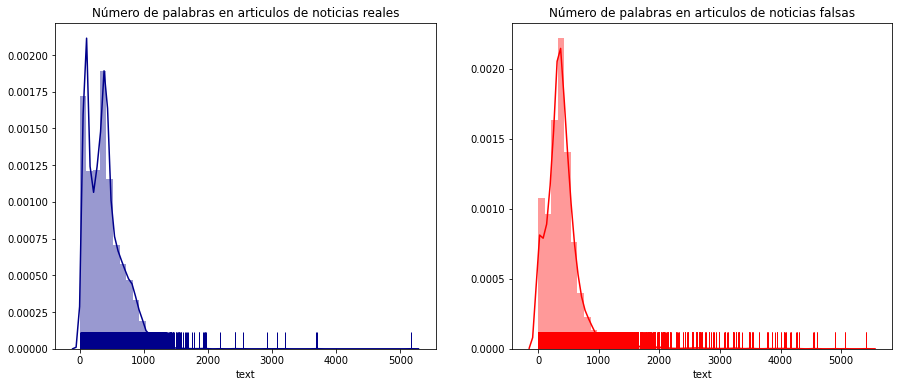

In [27]:
import seaborn as sns
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.distplot(words_per_article_plot_t, ax = ax[0], color = "darkblue", rug = True).set_title("Número de palabras en articulos de noticias reales")
sns.distplot(words_per_article_plot_f, ax = ax[1], color = "red", rug = True).set_title("Número de palabras en articulos de noticias falsas")

En este primer analisis quisimos observar si el número de palabras del articulo tiene alguna relación con la categoría de la noticia, efectivamente encontramos que las fake news tienden <br/>  a ser mas largas que las noticias reales

**Entendimiento de titulos de las noticias**

In [28]:
words_per_headline_plot_t = true["title"].apply(lambda x: len(x.split()))
stdev_t_head = statistics.stdev(words_per_headline_plot_t)
words_per_headline_t = words_per_headline_plot_t.sum()/len(true["title"])

words_per_headline_plot_f = fake["title"].apply(lambda x: len(x.split()))
stdev_f_head = statistics.stdev(words_per_headline_plot_f)
words_per_headline_f = words_per_headline_plot_f.sum()/len(fake["title"])

print ("The average number of words in a real news article is ", words_per_headline_t)
print ("The average number of words in a fake news article is ", words_per_headline_f)

print ("The standard deviation in real news article lengths is ", stdev_t_head)
print ("The standard deviation in fake news article lengths is ", stdev_f_head)

The average number of words in a real news article is  9.95506718924972
The average number of words in a fake news article is  14.739588217741591
The standard deviation in real news article lengths is  1.7023882044303849
The standard deviation in fake news article lengths is  4.326850621887219


Text(0.5, 1.0, 'Número de palabras en títulos de noticias falsas')

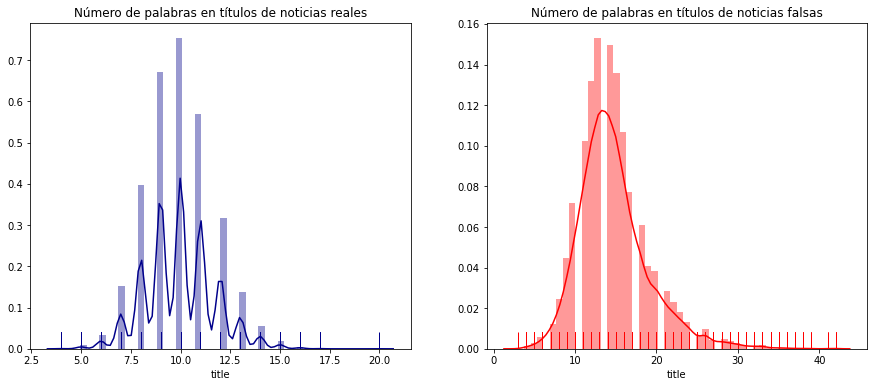

In [31]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.distplot(words_per_headline_plot_t, ax = ax[0], color = "darkblue", rug = True).set_title("Número de palabras en títulos de noticias reales")
sns.distplot(words_per_headline_plot_f, ax = ax[1], color = "red", rug = True).set_title("Número de palabras en títulos de noticias falsas")

En este analisis quisimos observar si el número de palabras del título tiene alguna relación con la categoría de la noticia, efectivamente encontramos que los títulos de las  <br/> fake news tienden a ser mas largos que los de las noticias reales

#### **Normalización**
Para la normalización de los datos se realiza una eliminación de prefijos y sufijos, además de realizar una lemmatización de los verbos.

In [32]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

total_news_text_df['words'] = total_news_text_df['words'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
print(total_news_text_df.head())

total_news_title_df['words'] = total_news_title_df['words'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
total_news_title_df.head()

12192    Does your child spend time on social media? Un...
11495    BERLIN (Reuters) - Ukrainian President Petro P...
20246    THE COMMON THREAD IN ALL THIS IS HATE   THE HA...
4243     BEIJING (Reuters) - The 100-day trade talks an...
18545    Rush Limbaugh nails it in the transcript below...
Name: text, dtype: object


12192    HOW BUZZFEED Is Using Social Media “News” Feed...
11495    Ukraine's Poroshenko vows to work for quick ex...
20246    #BlackLivesMatter Supporters Say No Connection...
4243     you.S. business wary of skin-deep results from...
18545    RUSH LIMBAUGH: This Group is “Roadblocking” Tr...
Name: title, dtype: object

Por ultimo convertimos la columna que contiene el arreglo de palabras, de una lista a una cadena de caracteres para la posterior manipulación de los mismos al hacer la preparación de los datos para el modelo.

In [33]:
total_news_text_df['words'] = total_news_text_df['words'].apply(lambda x: ' '.join(map(str, x)))
total_news_text_df

12192    Does your child spend time on social media? Un...
11495    BERLIN (Reuters) - Ukrainian President Petro P...
20246    THE COMMON THREAD IN ALL THIS IS HATE   THE HA...
4243     BEIJING (Reuters) - The 100-day trade talks an...
18545    Rush Limbaugh nails it in the transcript below...
                               ...                        
578      WASHINGTON (Reuters) - you.S. President Donald...
17199    The Confederate Battle Flag will be taken down...
2439     (Reuters) - TransCanada Corp, Canada’s No.2 pi...
2155     At a town hall in Frost, Texas last week a vot...
words    12192    child spend tim soc med unless am pro...
Name: text, Length: 35913, dtype: object

In [34]:
total_news_title_df['words'] = total_news_title_df['words'].apply(lambda x: ' '.join(map(str, x)))
total_news_title_df

12192    HOW BUZZFEED Is Using Social Media “News” Feed...
11495    Ukraine's Poroshenko vows to work for quick ex...
20246    #BlackLivesMatter Supporters Say No Connection...
4243     you.S. business wary of skin-deep results from...
18545    RUSH LIMBAUGH: This Group is “Roadblocking” Tr...
                               ...                        
578      White House promises welfare overhaul details ...
17199    SOUTH CAROLINA TO REMOVE CONFEDERATE FLAG AS B...
2439     TransCanada to make final decision on Keystone...
2155      Texas GOPer Angrily Demands Voter ‘SHUT UP’ W...
words    12192    buzzfee us soc med new fee teach whit...
Name: title, Length: 35913, dtype: object

## 3. Modelo

Vamos a usar Bayes binomial como algoritmo para la predicción

In [36]:
estimators = [('transform', CountVectorizer(stop_words='english')), ('clf', BernoulliNB())]
pipe = Pipeline(estimators)

Para el tratamiento de nuestros datos, tomamos la decisión de trabajar con textos y títulos, de manera que, para el análisis de nuestros resultados estarán enfocados en estos dos aspectos. Por lo tanto, para el modelo entrenaremos dos veces, es decir, un entrenamiento con textos y otro con títulos.

Con ayuda del GridSearch vamos a buscar la mejor combinación de hiperparámetros para el modelo con Textos

In [39]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

parameters = [
        {'transform': (TfidfVectorizer(stop_words='english'), CountVectorizer(stop_words='english')),
         'clf': (BernoulliNB(),),
         'clf__alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)
        },
        {'transform': (TfidfVectorizer(stop_words='english'), CountVectorizer(stop_words='english')),
         'clf': (RandomForestClassifier(),AdaBoostClassifier()),
         'clf__n_estimators': (10,20,50)
        },
]
grid_search_text = GridSearchCV(pipe, param_grid=parameters,verbose = 20,n_jobs=-1,error_score=0.0)
grid_search_text.fit(X_train_text,y_train_text)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

GridSearchCV(error_score=0.0,
             estimator=Pipeline(steps=[('transform',
                                        CountVectorizer(stop_words='english')),
                                       ('clf', BernoulliNB())]),
             n_jobs=-1,
             param_grid=[{'clf': (BernoulliNB(),),
                          'clf__alpha': (1, 0.1, 0.01, 0.001, 0.0001, 1e-05),
                          'transform': (TfidfVectorizer(stop_words='english'),
                                        CountVectorizer(stop_words='english'))},
                         {'clf': (RandomForestClassifier(),
                                  AdaBoostClassifier()),
                          'clf__n_estimators': (10, 20, 50),
                          'transform': (TfidfVectorizer(stop_words='english'),
                                        CountVectorizer(stop_words='english'))}],
             verbose=20)

Imprimimos cual es la mejor combinación que arrojó el algoritmo

In [41]:
grid_search_text.best_estimator_

Pipeline(steps=[('transform', TfidfVectorizer(stop_words='english')),
                ('clf', AdaBoostClassifier())])

Con ayuda del GridSearch vamos a buscar la mejor combinación de hiperparámetros para el modelo con Títulos

In [42]:
grid_search_title = GridSearchCV(pipe, param_grid=parameters,verbose = 20,n_jobs=-1,error_score=0.0)
grid_search_title.fit(X_train_title,y_train_title)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

GridSearchCV(error_score=0.0,
             estimator=Pipeline(steps=[('transform',
                                        CountVectorizer(stop_words='english')),
                                       ('clf', BernoulliNB())]),
             n_jobs=-1,
             param_grid=[{'clf': (BernoulliNB(alpha=1),),
                          'clf__alpha': (1, 0.1, 0.01, 0.001, 0.0001, 1e-05),
                          'transform': (TfidfVectorizer(stop_words='english'),
                                        CountVectorizer(stop_words='english'))},
                         {'clf': (RandomForestClassifier(),
                                  AdaBoostClassifier()),
                          'clf__n_estimators': (10, 20, 50),
                          'transform': (TfidfVectorizer(stop_words='english'),
                                        CountVectorizer(stop_words='english'))}],
             verbose=20)

In [43]:
grid_search_title.best_estimator_

Pipeline(steps=[('transform', TfidfVectorizer(stop_words='english')),
                ('clf', BernoulliNB(alpha=1))])

## 4. Predicción

Realizamos la predicción con el mejor modelo encontrado con el GridSearch para textos y títulos

In [53]:
gs_text = grid_search_text.best_estimator_
y_pred_gs_text = gs_text.predict(X_test_text)
y_pred_gs_text

array(['True', 'Fake', 'Fake', ..., 'Fake', 'True', 'Fake'], dtype=object)

In [45]:
gs_title = grid_search_title.best_estimator_
y_pred_gs_title = gs_title.predict(X_test_title)
y_pred_gs_title

array(['True', 'True', 'Fake', ..., 'Fake', 'True', 'Fake'], dtype='<U4')

## 5. Validación

Mostramos la matriz de clasificación con el mejor resultado de GridSearchCV, tanto para textos como para títulos

In [60]:
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve

report_NB_GS_text = classification_report(y_test_text, y_pred_gs_text)

print("Test Report for text using Adaboost: \n", report_NB_GS_text)
#print("Confusion Matrix for Näive Bayes\n", confusion_matrix(y_test_text, y_pred_gs_text))

Test Report for text using Adaboost: 
               precision    recall  f1-score   support

        Fake       1.00      0.99      0.99      4665
        True       0.99      1.00      0.99      4314

    accuracy                           0.99      8979
   macro avg       0.99      0.99      0.99      8979
weighted avg       0.99      0.99      0.99      8979



Confussion Matrix for titles using Adaboost : 



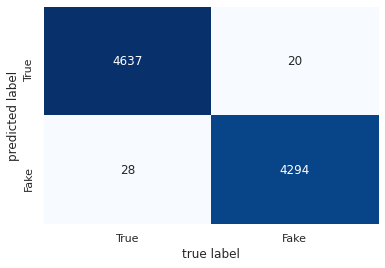

In [62]:
import seaborn as sns; sns.set()
mat_test = confusion_matrix(y_test_text, y_pred_gs_text)
print("Confussion Matrix for titles using Adaboost : \n")
sns.heatmap(mat_test.T, square=False, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=total_news_df['category'].unique(),
            yticklabels=total_news_df['category'].unique())
plt.xlabel('true label')
plt.ylabel('predicted label');

In [56]:
report_NB_GS_title = classification_report(y_test_title, y_pred_gs_title)

print("Test Report for Titles using Näive Bayes\n", report_NB_GS_title)

Test Report for Titles using Näive Bayes
               precision    recall  f1-score   support

        Fake       0.95      0.95      0.95      4665
        True       0.94      0.95      0.95      4314

    accuracy                           0.95      8979
   macro avg       0.95      0.95      0.95      8979
weighted avg       0.95      0.95      0.95      8979



Confussion Matrix for titles using Näive Bayes : 



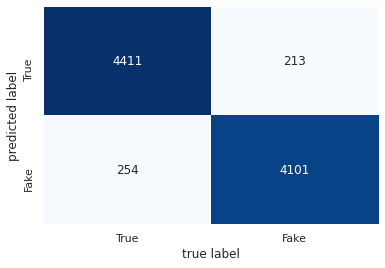

In [57]:
import seaborn as sns; sns.set()
mat_test = confusion_matrix(y_test_title, y_pred_gs_title)
print("Confussion Matrix for titles using Näive Bayes : \n")
sns.heatmap(mat_test.T, square=False, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=total_news_df['category'].unique(),
            yticklabels=total_news_df['category'].unique())
plt.xlabel('true label')
plt.ylabel('predicted label');

## 6. Conclusiones
* Usamos el algoritmo de clasificación de Bernoulli  Naive Bayes como base de nuestro modelo ya que por experiencia sabemos que es rápido y fácil de usar.

* Solo usando el algoritmo de Bernoulli Naive Bayes nos dimos cuenta que su desempeño (Accuracy) fue bastante bueno.

* Teniendo en cuenta que se requiere una solución de clasificación binaria, utilizamos el algoritmo Bernoulli Naive Bayes que permite hacer la predicción de la variable de salida sin tener que hacer una transformación numérica. 

* Pudimos observar que el proceso de lemmatización y stemming reduce considerablemente el numero de palabras para hacer el entrenamiento del algoritmo y así mismo  mejora las métricas de rendimiento del mismo.

* En este caso el conjunto de datos se encuentra balanceado, por lo tanto las métricas de error son bastante buenas para todas las clases a clasificar, lo que permite concluir que el modelo generaliza bastante bien.

* Para poder verificar que el algoritmo de Bernoulli Naive Bayes era el más adecuado para el contexto del problema, hicimos un gridsearch que comprendía la utilización de otros algoritmos de clasificación diferentes tales como Adaboost y RandomForest, donde obtuvimos que para la clasificación de las noticias de acuerdo con los textos, hubo mejor desempeño con el Adaboost y para los titulos hubo mejor desempeño con el Bernoulli Naive Bayes.

* En el objetivo inicial se planteo un modelo que entregara un accuracy del 95%. Sin embargo, para este obtuvimos un 99%, lo cual supero las expectativas del negocio.

* Adicionalmente, se planteo que el modelo pudiese clasificar noticias de diferentes contextos, lo cual se logro y ademas se agregaron fuentes nuevas.

* Podemos notar que los resultados de accuracy para el modelo con textos (99%) es un poco mejor que para el modelo con titulos (95%), por lo tanto, podemos decir que nuestro modelo con textos es el adecuado para la clasificación de noticias.